In [8]:
# This might take a significant amount of time!
# Print a list of single channel coin images and other images
import os
from PIL import Image

coin_path = r'C:\Users\Mate\Projects\Coin\data\coin_256x256' # Replace with path to coin images
others_path = r'C:\Users\Mate\Projects\Coin\data\others_256x256' # Replace with path to other images

def list_monochromes(input_path):
    file_list = os.listdir(input_path)
    monochrome_list = []

    for item in file_list:
        if item != 'desktop.ini':
            current_image = Image.open(input_path + '\\' + item)
            if len(current_image.getbands()) == 1:
                monochrome_list.append(item)
            current_image.close()    

    return monochrome_list

print(list_monochromes(coin_path))
print(list_monochromes(others_path))

In [13]:
#Only use 10k images from coin and other each (20k total)
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# Define the paths to the subfolders
folder_path1 = r'C:\Users\Mate\Projects\Coin\data\coin_256x256'
folder_path2 = r'C:\Users\Mate\Projects\Coin\data\others_256x256'

# Function to load a subset of images from a folder
def load_subset_images(folder_path, num_images):
    file_list = os.listdir(folder_path)
    # Ensure you have a maximum of num_images
    num_images = min(num_images, len(file_list))
    
    # Randomly select num_images from the list of files
    selected_files = random.sample(file_list, num_images)
    
    # Create a list of (image_path, label) pairs
    image_paths = [os.path.join(folder_path, file) for file in selected_files]
    
    # Label for this subset can be determined based on the folder it came from
    label = 1 if "coin_" in folder_path else 0
    
    # Create a list of (image_path, label) pairs
    dataset = [(image_path, label) for image_path in image_paths]
    
    return dataset

# Load subsets of images from the two subfolders
num_images_per_folder = 10000
subset1 = load_subset_images(folder_path1, num_images_per_folder)
subset2 = load_subset_images(folder_path2, num_images_per_folder)

# Combine the subsets
combined_dataset = subset1 + subset2

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        image = image.to("cuda")
        label = label.to("cuda")
        return image, label

# Transform the data 
transforms = transforms.Compose([
    # transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) -> Investigate!
])

# Create a custom dataset
custom_dataset = CustomDataset(combined_dataset, transform=transforms)

# Define dataset sizes
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

# Split the data
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Create data loaders for the splits
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Pytorch CNN: 
import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Docs: 
# https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model 
# https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

class CoinClassifier(nn.Module):
    def __init__(self, input_size):
        super(CoinClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(12) # -> Investigate!
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        #self.fc1 = nn.Linear(24*10*10, 10)
        
        # Calculate the size of the first linear layer based on the input size
        self.first_linear_size = self.calculate_first_linear_size(input_size)

        self.fc1 = nn.Linear(self.first_linear_size, 1)

    def calculate_first_linear_size(self, input_size):
        # Compute the output size after passing through the convolutional and pooling layers
        conv1_output = ((input_size - 3 + 2 * 1) // 2) + 1
        conv2_output = ((conv1_output - 5 + 2 * 1) + 1)
        pool_output = conv2_output // 2
        conv4_output = ((pool_output - 5 + 2 * 1) + 1)
        conv5_output = ((conv4_output - 5 + 2 * 1) + 1)

        # Calculate the size of the flattened vector for the linear layer
        first_linear_size = 24 * conv5_output * conv5_output

        return first_linear_size

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        #output = output.view(-1, 24*10*10)
        output = output.view(-1, self.first_linear_size)
        output = self.fc1(output)
        output = torch.sigmoid(output)

        return output

# Define the input size based on your data
input_size = 256

model = CoinClassifier(input_size).to(device)
print(model)

Using cuda device
CoinClassifier(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=83544, out_features=1, bias=True)
)


In [15]:
# Loss function and optimizer algorithm
from torch.optim import Adam

# Binary Cross Entropy - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html 
loss_fn = nn.BCELoss(reduction='mean')
# Adam - Gradient Descent
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001) # -> Investigate the lr and weight-decay

Accuracy: 0.6733
Precision: 0.6623
Recall: 0.7511
F1 Score: 0.7039
ROC AUC: 0.7354


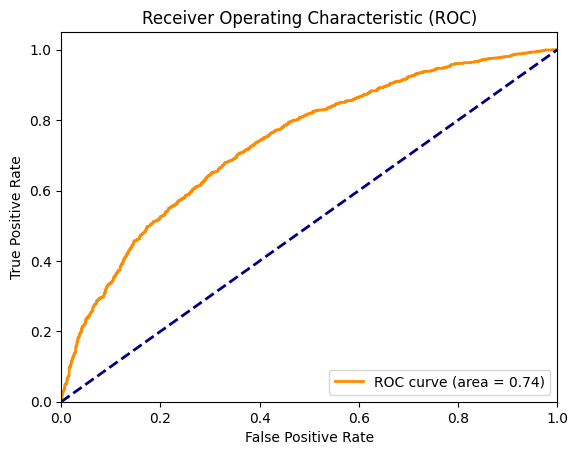

In [21]:
#Training loop
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

epochs = 1

for epoch in range(epochs):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        labels = labels.view(-1, 1).float()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()


#Validation Loop
model.eval()
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
model.train()

#Testing Loop
model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)


#Collect and calculate metrics
true_labels = []  # List to store true labels
predicted_probs = []  # List to store predicted probabilities
predicted_labels = []  # List to store predicted labels
model.eval()  # Set the model in evaluation mode

with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        outputs = outputs.cpu()
        labels = labels.cpu().numpy()
        true_labels.extend(labels)
        predicted_probs.extend(torch.sigmoid(outputs).cpu().numpy())
        predicted_labels.extend((outputs >= 0.5).numpy())

true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probs)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

